# **Lab assignment - Image segmentation applied to remote sensing (basic to advanced)**

**Master 2 GeoData Science**

*2021-2022*

## Introduction
For this lab, we will again work with the **Scikit-image** library and also the **OpenCV** library. The objective is to experiment some basic and advanced methods for image segmentation applied to some selected remote sensing images. This lab assignment includes 4 exercises: 

* Exo1: Manual thesholding and histogram-based thresholding for segmentation
* Exo2: Clustering-based segmentation
* Exo3: Watershed segmentation and dealing with over-segmentation
* Exo4: Efficient Graph-Based Image Segmentation by Felzenszwalb & Huttenlocher (paper that you like alot !!!)

**Submit your work on Moodle by November 20 !!! Remember that your work should contain codes, results as well as your analysis or remark on the obtained results**

Before starting, if you prefer to work on image files from your Drive, let mount your drive to allow Colab to acess to your Google Drive. Otherwise, upload the image files at each time you connect to the Colab server.

In [34]:
# Mount drive to allow Colab to access to your Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [35]:
# Import all the libraries needed for this session
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
from skimage.segmentation import slic, mark_boundaries, felzenszwalb
import cv2 as cv2
from skimage.morphology import watershed, extrema
from scipy.ndimage.morphology import morphological_gradient
from skimage.feature import peak_local_max
from scipy import ndimage
from PIL import Image
from scipy.ndimage.measurements import label
from scipy import misc

Let's first open and visualize a Postdam RGB 2 image (TIFF file) to make sure that everything goes well. You would be then ready to tackle the exercises.

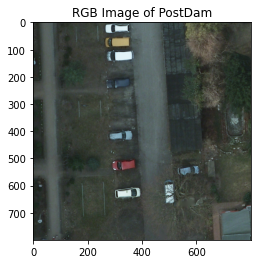

In [36]:
# Open and vizualize the RGB image "potsdam_RGB_2.tiff" (Image source: https://www2.isprs.org/commissions/comm2/wg4/benchmark/2d-sem-label-potsdam/)
potsdam_rgb = tiff.imread("/content/drive/MyDrive/UBS/Computer Vision/Graph-based Processing/Lab/potsdam_RGB_2.tiff")
potsdam_rgb = np.asarray(potsdam_rgb)
potsdam_rgb = potsdam_rgb[:,:,0:3]
plt.imshow(potsdam_rgb)
plt.title("RGB Image of PostDam")
plt.show()

### **Exo 1: Threshold-based segmentation**

(Note that the segmentation results using thresholding methods are not perfect!) 

#### *Question 1.1)*
Compute and visualize a gray-scale version of potsdam_rgb using the formula 

```
potsdam_gray = 0.298xRed + 0.587xGreen + 0.114xBlue
```

and round the values to integers.

In [37]:
# Your work here
# round values to integers
Red = potsdam_rgb[:,:,0].astype('int')
Green = potsdam_rgb[:,:,1].astype('int')
Blue = potsdam_rgb[:,:,2].astype('int')

# compute the gray version of the postdam image using the formula
potsdam_gray = 0.298*Red + 0.587*Green + 0.114*Blue 
potsdam_gray = potsdam_gray.astype('int')

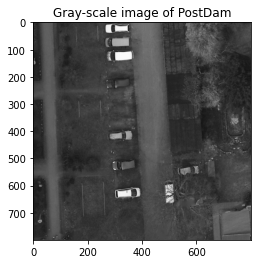

In [38]:
plt.imshow(potsdam_gray, cmap='gray')
plt.title("Gray-scale image of PostDam")
plt.show()

#### *Question 1.2)*

Compute and visualize the histogram of gray values of *potsdam_gray*.

To compute the histogram, you can use the Numpy function:

```
histogram, bins_ = np.histogram(img, bins)
```

and to visualize the histogram, plot it with the Matplotlib function:

```
plt.bar(X, Y)
```




<BarContainer object of 254 artists>

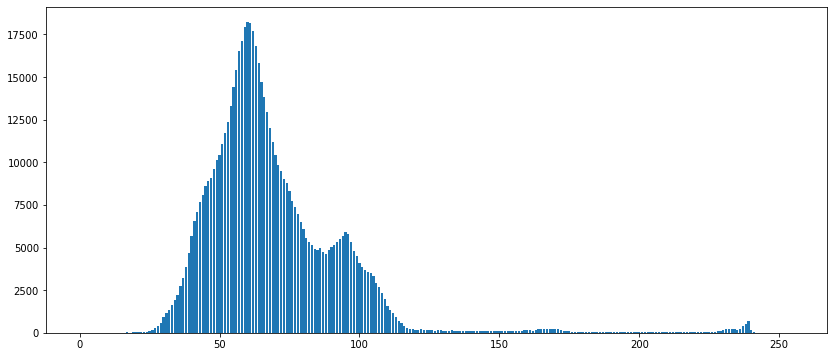

In [39]:
# Your work here
#plt.hist(potsdam_gray.flatten(), range=(0, 255))
plt.figure(figsize=(14, 6))
histogram, bins_ = np.histogram(potsdam_gray, bins=range(255))
plt.bar(bins_[1:], histogram)

#### *Question 1.3)*

Based on the histogram of *potsdam_gray*, extract the light-gray cars by thresholding the gray scale image. 

Can we do the same for the black car?

Note that the results won't be perfect.

Text(0.5, 1.0, 'Extracted Light-gray cars in the postdam area')

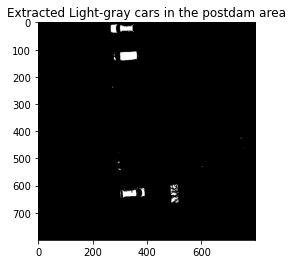

In [40]:
# Your work here
light_car = potsdam_gray >180 #115 #175
plt.imshow(light_car, cmap = 'gray')
plt.title("Extracted Light-gray cars in the postdam area")

Text(0.5, 1.0, 'Extracted Dark Car')

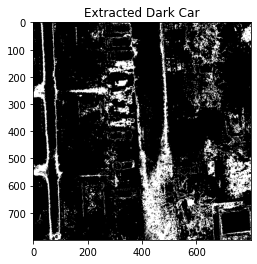

In [41]:
lesser = potsdam_gray > 70
greater = potsdam_gray < 85
dark_car = np.logical_and(lesser, greater)

plt.imshow(dark_car, cmap = 'gray')
plt.title("Extracted Dark Car")

Due to the large similarity of the black car pixels with the background, it is difficult to properly discriminate it from the background as seen above. Hence, a similar thresholding of the pixel values does not appear to be sufficient. 

#### *Question 1.4)*

What if we want to segment the red car? This time, we need the RGB version of this image.

Apply different threhsold values for each channel (For example: Red>120, Green<80 and Blue < 80)

Text(0.5, 1.0, 'Histogram of the green band')

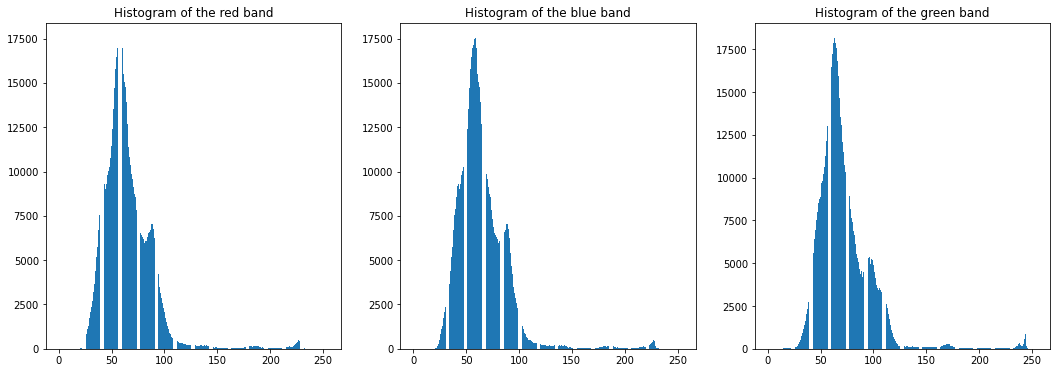

In [42]:
# Your work here
# See the histogram of each band
fig, axs = plt.subplots(1, 3, figsize = (18, 6))
red_histogram, bins_ = np.histogram(Red, bins=range(255))
blue_histogram, bins2 = np.histogram(Blue, bins=range(255))
green_histogram, bins3 = np.histogram(Green, bins=range(255))

axs[0].bar(bins_[1:], red_histogram)
axs[0].set_title('Histogram of the red band')
axs[1].bar(bins_[1:], red_histogram)
axs[1].set_title('Histogram of the blue band')
axs[2].bar(bins3[1:], green_histogram)
axs[2].set_title('Histogram of the green band')



Text(0.5, 1.0, 'Extracted red car')

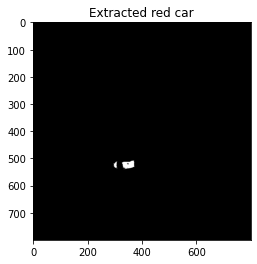

In [43]:
#extract the red car
# Red>120, Green<80 and Blue < 80

red = (Red > 120).astype('int')
green = (Green < 80).astype('int')
blue = (Blue < 80).astype('int')

red_car = np.logical_and(red, green, blue)

plt.imshow(red_car, cmap = 'gray')
plt.title("Extracted red car")

### **Exo 2: Clustering-based methods for segmentation**

Open and visualize the image "dolphins.jpg" 
(Image source: https://www.pexels.com/fr-fr/photo/mer-eau-ocean-ete-4321166/)



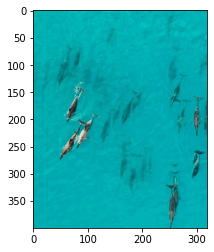

In [44]:
dolphins_rgb = plt.imread("/content/drive/MyDrive/UBS/Computer Vision/Graph-based Processing/Lab/dolphins.jpg")
dolphins_rgb = np.asarray(dolphins_rgb)
#dolphins_rgb = dolphins_rgb[100:300,100:300]
plt.imshow(dolphins_rgb)
plt.show()

In [45]:
dolphins_rgb.shape

(400, 320, 3)

#### *Question 2.1)*

As done previously, try to segment the twelve dolphins using thresholds on the three RGB channels.

Text(0.5, 1.0, 'Dolphins RGB Histogram')

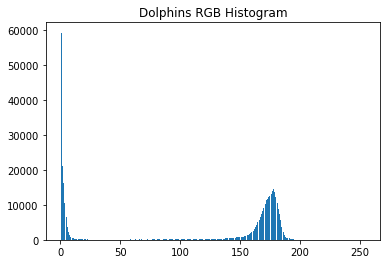

In [46]:
# display the image histogram 
histogram, bins_ = np.histogram(dolphins_rgb, bins=range(255))
plt.bar(bins_[1:], histogram)
plt.title("Dolphins RGB Histogram")

Text(0.5, 1.0, 'Dolphins image blue band')

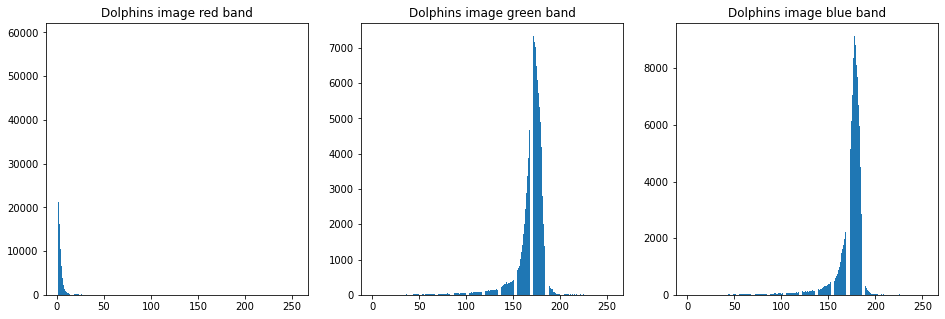

In [47]:
# See the histogram of each band
# Disaggregate the rgb band into its constituent bands and display their histogram

fig, axs = plt.subplots(1, 3, figsize = (16, 5))
red_histogram, bins_ = np.histogram(dolphins_rgb[:, :, 0], bins=range(255))
green_histogram, bins2 = np.histogram(dolphins_rgb[:, :, 1], bins=range(255))
blue_histogram, bins3 = np.histogram(dolphins_rgb[:, :, 2], bins=range(255))

axs[0].bar(bins_[1:], red_histogram)
axs[0].set_title('Dolphins image red band')
axs[1].bar(bins_[1:], green_histogram)
axs[1].set_title('Dolphins image green band')
axs[2].bar(bins3[1:], blue_histogram)
axs[2].set_title('Dolphins image blue band')

Text(0.5, 1.0, 'Extracted dolphins')

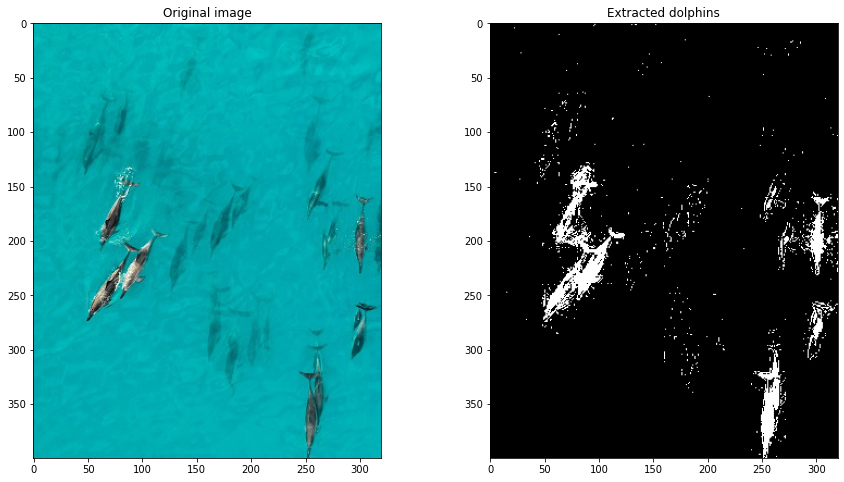

In [48]:
# your work
# extract the dolphins based on intensity thresholds

red = (dolphins_rgb[:, :, 0] > 9).astype('int')
green = (dolphins_rgb[:, :, 1] > 50).astype('int')
blue = (dolphins_rgb[:, :, 2]  > 40).astype('int')

dolphins = np.logical_and(red, green, blue)
figure, axs = plt.subplots(1, 2, figsize = (15, 8))
axs[0].imshow(dolphins_rgb)
axs[0].set_title("Original image")
axs[1].imshow(dolphins, cmap = 'gray')
axs[1].set_title("Extracted dolphins")

As seen in the number of dolphins extracted from the original image above, we can tell that the underwater images were mostly captured bu the red band and only shows their edge information. 

#### *Question 2.2)*
Now, let's perform SLIC super-pixel segmentation using the *segmentation.slic* method with parameters
- compactness 
- number of segments 

Try different different values compactness and number of segments. Which combination helps you to obtain a satisfied superpixel masks ?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  """Entry point for launching an IPython kernel.


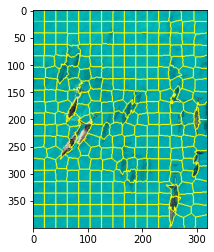

In [49]:
segments = slic(dolphins_rgb, n_segments=300, compactness= 20)
plt.imshow(mark_boundaries(dolphins_rgb, segments))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  del sys.path[0]


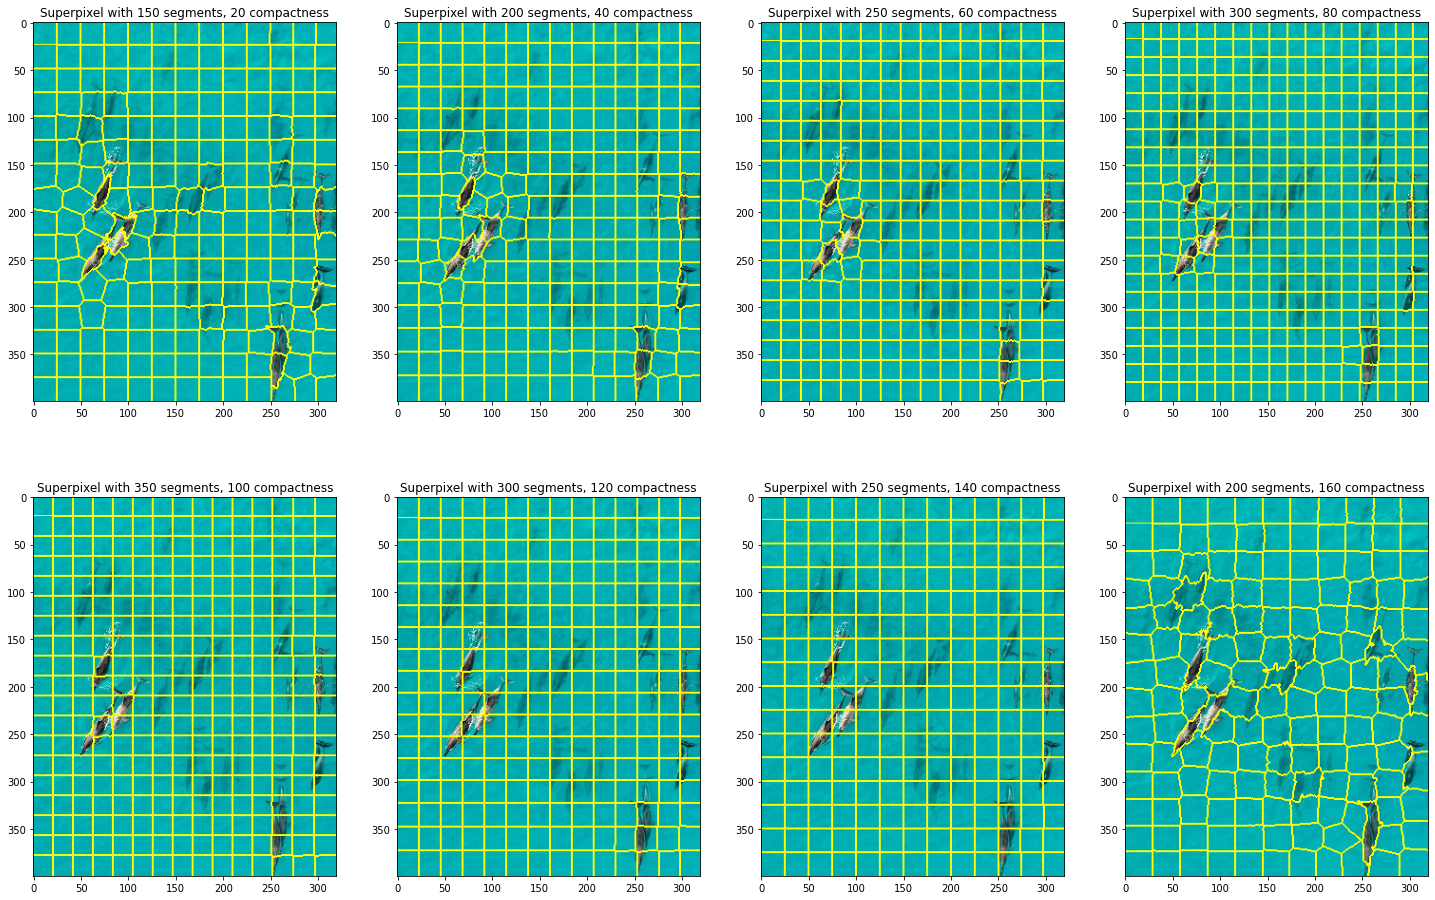

In [50]:
# your work here
# set different combination for the compactness and the number of segments in 
# the SLIC segmentation algorithm. 

compact = [20, 40, 60, 80, 100, 120, 140, 160]
num_segments = [150, 200, 250, 300, 350, 300, 250, 200]
#fig, axs = plt.subplots(9)
fig, axs = plt.subplots(2, 4, figsize=(25, 16))
#plt.subplots_adjust(hspace=0.5)

#fig, axs = plt.subplots("Superpixels -- %d segments" %(seg))
for c, seg, ax in zip(compact, num_segments, axs.ravel()):
    segments = slic(dolphins_rgb, n_segments=seg, compactness= c)
    plt.imshow(mark_boundaries(dolphins_rgb, segments))
    plt.sca(ax)
    plt.title("Superpixel with %d segments, %d compactness" %(seg, c))

Which combination helps you obtain a satisfied superpixel masks?

The best superpixel mask for extracting the dolphins is segmentaion with number of segments set to 200 and the compactness set to 160. 

#### *Question 2.3)*

Now, let us try with the clustering methods: first with K-means.

To segment using the K-means method, we will consider two pixels representation:

- RGB values

- RGB value + pixels position

To segment using the K-means algorithm, use the following function:

```
kmeans = KMeans(n_clusters, max_iter=150).fit(X)
segmentation = kmeans.predict(X)
```
where *n_clusters* corresponds to the *k* parameter. Try different values for the parameter *n_clusters*.

**Note: for this question, you can resize the image to 64*64 for faster computation**

Text(0.5, 1.0, 'Resized Image:: 128 by 128')

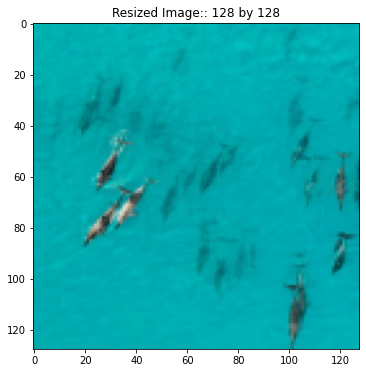

In [51]:
from skimage.transform import resize
resized_dolphins = resize(dolphins_rgb, (128, 128), anti_aliasing=True)
plt.figure(figsize=(14, 6))
plt.imshow(resized_dolphins, cmap='gray')
plt.title('Resized Image:: 128 by 128')

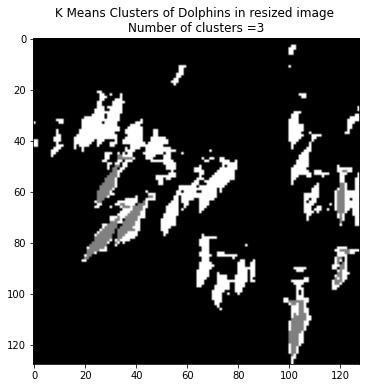

In [52]:
# Extract the Red, Green and Blue Band from the image
re_red = resized_dolphins[:, :, 0]
re_green = resized_dolphins[:, :, 1]
re_blue = resized_dolphins[:, :, 2]

init_shape = re_red.shape

# Create image clusters
data_sample = np.column_stack([re_red.flatten(), re_green.flatten(), re_blue.flatten()])
model = KMeans(n_clusters=3, max_iter=150, random_state=0).fit(data_sample)
segments = model.predict(data_sample).reshape(init_shape)

# Display segments
plt.figure(figsize=(14, 6))
plt.imshow(segments, cmap='gray')
plt.title("K Means Clusters of Dolphins in resized image \nNumber of clusters =3")
plt.show()

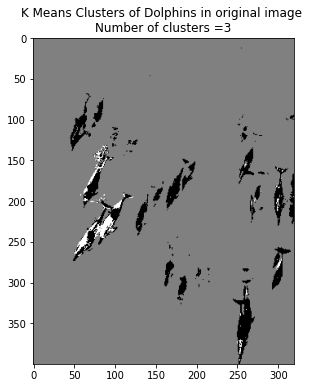

In [53]:
# your work here
# Extract the Red, Green and Blue Band from the image
red = dolphins_rgb[:, :, 0].astype('int')
green = dolphins_rgb[:, :, 1].astype('int')
blue = dolphins_rgb[:, :, 2].astype('int')

init_shape = red.shape

# Create image clusters
data_sample = np.column_stack([red.flatten(), green.flatten(), green.flatten()])
model = KMeans(n_clusters=3, max_iter=150, random_state=0)
segments = model.fit_predict(data_sample).reshape(init_shape)

# Display segments
plt.figure(figsize=(14, 6))
plt.imshow(segments, cmap='gray')
plt.title("K Means Clusters of Dolphins in original image \nNumber of clusters =3")
plt.show()

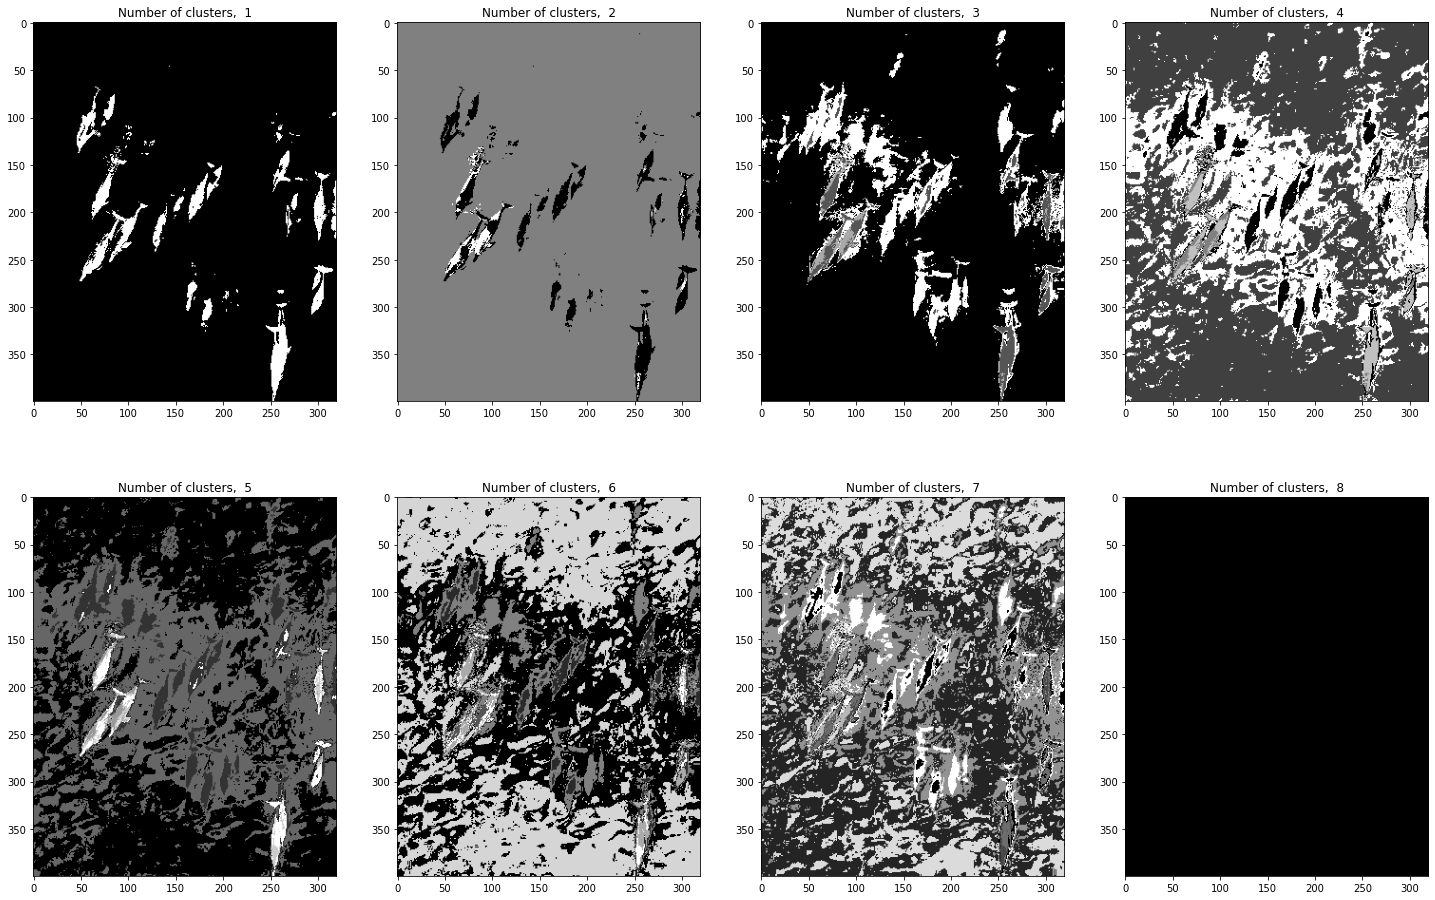

In [54]:
# Try different values for the n-cluster
no_clusters = [1, 2, 3, 4, 5, 6, 7, 8]
fig, axs = plt.subplots(2, 4, figsize=(25, 16))

for v, ax in zip(no_clusters, axs.ravel()):
  model = KMeans(n_clusters=v, max_iter=150, random_state=0)
  segments = model.fit_predict(data_sample).reshape(init_shape).astype('int')
  plt.imshow(segments, cmap='gray')
  plt.sca(ax)
  plt.title("Number of clusters,  %d" %(v))

In [55]:

def KMeans_Seg(n_clusters, image):
  # extract the pixel location. 
  x, y = np.meshgrid(range(image.shape[0]), range(image.shape[1]))
  # concatenate RGB and pixel positions
  X = np.concatenate((image.reshape(-1, 3), x.reshape(-1, 1), y.reshape(-1, 1)), axis = 1)
  i, j, k = image.shape
  
  # perform kmeans clustering and display result
  model = KMeans(n_clusters=n_clusters, max_iter=150, random_state=0)
  model = model.fit(X)
  segments = model.predict(X)
  segments = segments.reshape(i, j)
  return segments

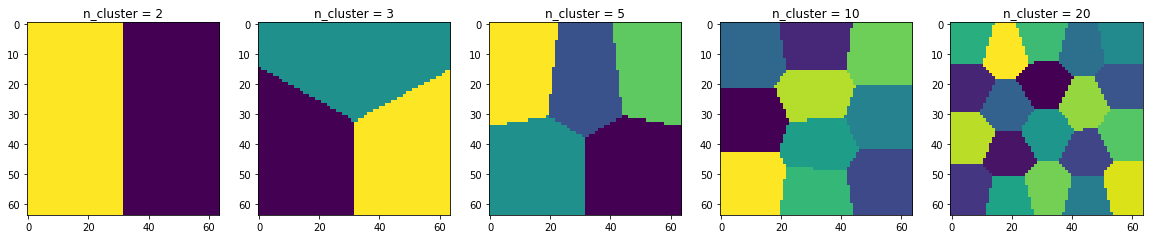

In [56]:
dolphins_resized = resize(dolphins_rgb, (64, 64))
no_cluster = [2, 3, 5, 10, 20]
fig, axes = plt.subplots(1,5, figsize=(20,15))

for i in range(len(no_cluster)):
    segments = KMeans_Seg(no_cluster[i], dolphins_resized)
    axes[i].imshow(segments)
    axes[i].set_title("n_cluster = %d" % no_cluster[i])
plt.show()

### **Exo 3: Let's try a more advanced method: Watershed**

###  Watershed segmentation - Reminder

Gray-scale images can be visualized as 3D surfaces: 
- Gray-scale values proportional to altitudes
- *Local minimum:* connected pixels surrounded by pixels of strictly larger gray-levels
- *Catchment basin:* zone of influence of a minimum
- *Watershed lines:* frontiers between catchment basins

#### Question 3.1)

Compute the watershed segmentation of a gradient of *potsdam_gray*. 

For this task, we consider the Laplacian gradient. To prevent oversegmentation, we consider a smoothed version of *potsdam_gray* image. Let's follow the guide (see also the usage of skimage functions)

1 - Smooth the *potsdam_gray* image and compute its Laplacian gradient:

```
kernel = np.ones((5,5),np.float32)/25
smooth_image = cv2.filter2D(np.uint8(potsdam_gray),-1,kernel)

kernel = (np.array([[0, 1, 0], [1, -4, 1], [0,1,0]])).astype(np.float32)
laplacian_gradient = cv2.filter2D(np.uint8(smooth_image),-1,kernel)
```


2 - Then, find the local minima of the morphological gradient using the following function:

```
local_minima = extrema.local_minima(gradient)
```

which returns a binary matrix indicating which pixels belong to a local minima of the gradient.


3 - Visualize the local minima of the gradient.


4 - Label the local minima using the function:

```
structure = np.ones((3, 3), dtype=np.int) # 4-connectivity
labeled_minima, ncomponents = label(img, structure)
```

which assigns a different label to each white connected component of *img* (in our case, a white connected component is a local minimum). The parameter *structure* determines the connectivity of the pixels (usually 4 or 8).

5 - Compute the watershed segmentation of our gradient with:

```
watershed = watershed(gradient, labeled_minima)
```

which, given an image gradient and a set of markers (in this case, the set of local minima), returns the watershed segmentation of the gradient.

In [57]:
# Your work here
kernel = np.ones((5,5),np.float32)/25
smooth_image = cv2.filter2D(np.uint8(potsdam_gray),-1,kernel)

kernel = (np.array([[0, 1, 0], [1, -4, 1], [0,1,0]])).astype(np.float32)
laplacian_gradient = cv2.filter2D(np.uint8(smooth_image),-1,kernel)
local_minima = extrema.local_minima(laplacian_gradient)

Text(0.5, 1.0, 'Local minima of the laplacian gradient')

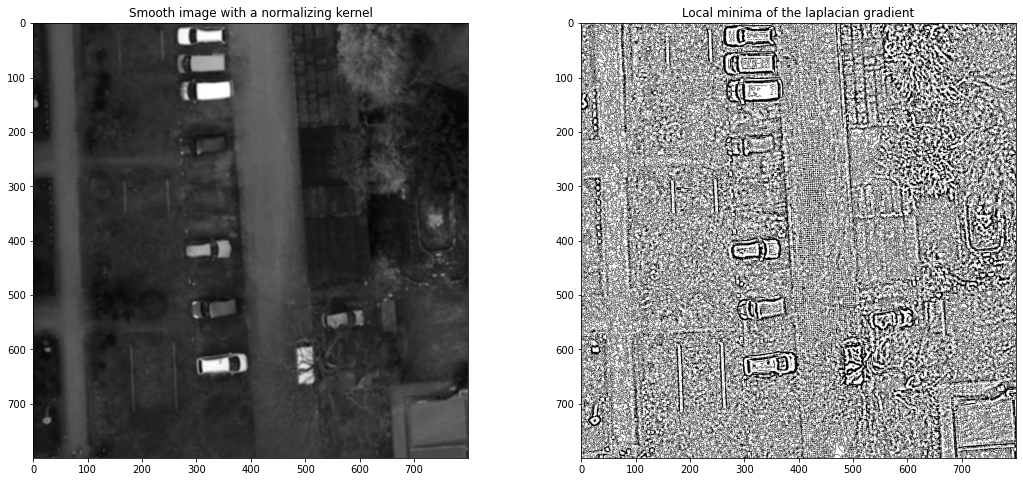

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))
# visualize the smoothed image
axs[0].imshow(smooth_image, cmap ='gray')
axs[0].set_title("Smooth image with a normalizing kernel")

# Visualize the laplacian gradient
axs[1].imshow(local_minima, cmap ='gray')
axs[1].set_title("Local minima of the laplacian gradient")

In [59]:
#Label the local minima
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.label.html 
structure = np.ones((3, 3), dtype=np.int) # 4-connectivity # structuring element
labeled_minima, ncomponents = label(local_minima, structure)
watershed_img = watershed(laplacian_gradient, labeled_minima)

/usr/local/lib/python3.7/dist-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Text(0.5, 1.0, 'Watershed Segmentation \nbased on the laplacian gradient and labelled minima')

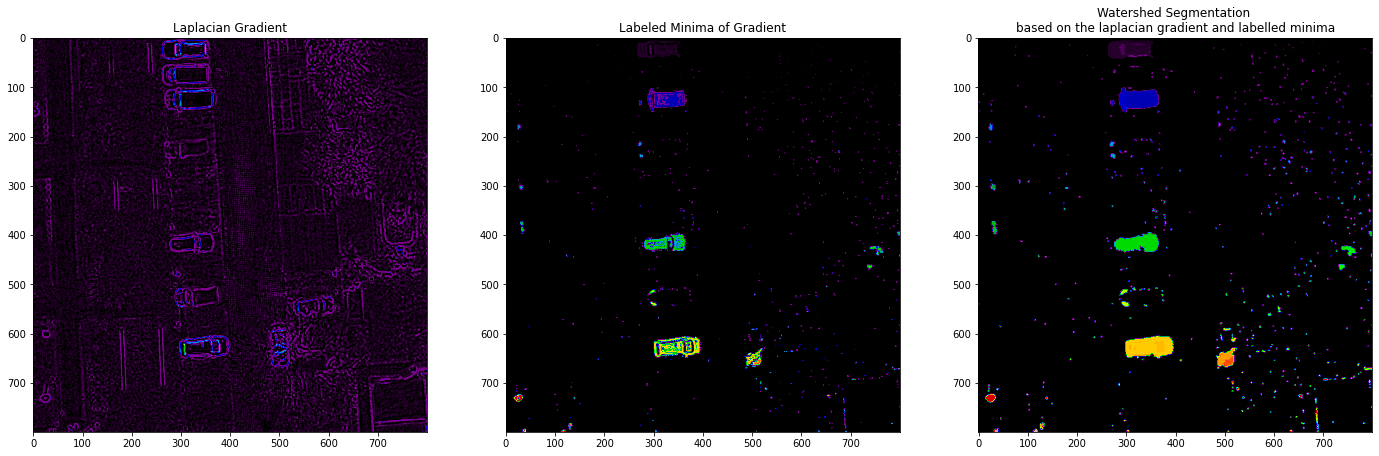

In [60]:
fig, axs = plt.subplots(1, 3, figsize = (24, 12))
axs[0].imshow(laplacian_gradient, cmap=plt.cm.nipy_spectral)
axs[0].set_title("Laplacian Gradient")

axs[1].imshow(labeled_minima, cmap=plt.cm.nipy_spectral)
axs[1].set_title("Labeled Minima of Gradient")

# display the watershed segments
axs[2].imshow(watershed_img, cmap=plt.cm.nipy_spectral)
axs[2].set_title("Watershed Segmentation \nbased on the laplacian gradient and labelled minima")

#### Question 3.2)

To deal with the oversegmentation problem of watershed segmentations, we can try other two solutions:

- use of a better image gradient

- marker watersheds: enforces local minima at the regions of interest; catchment basins are grown only from markers.


We first try to use a better image gradient. Open and vizualize the pre-computed gradient "potsdam_RGB_2_gradient.bmp", which was obtained using a deep learning based method. Then, compute the watershed segmentation from this gradient as done previously.

/usr/local/lib/python3.7/dist-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Watershed Segmentation')

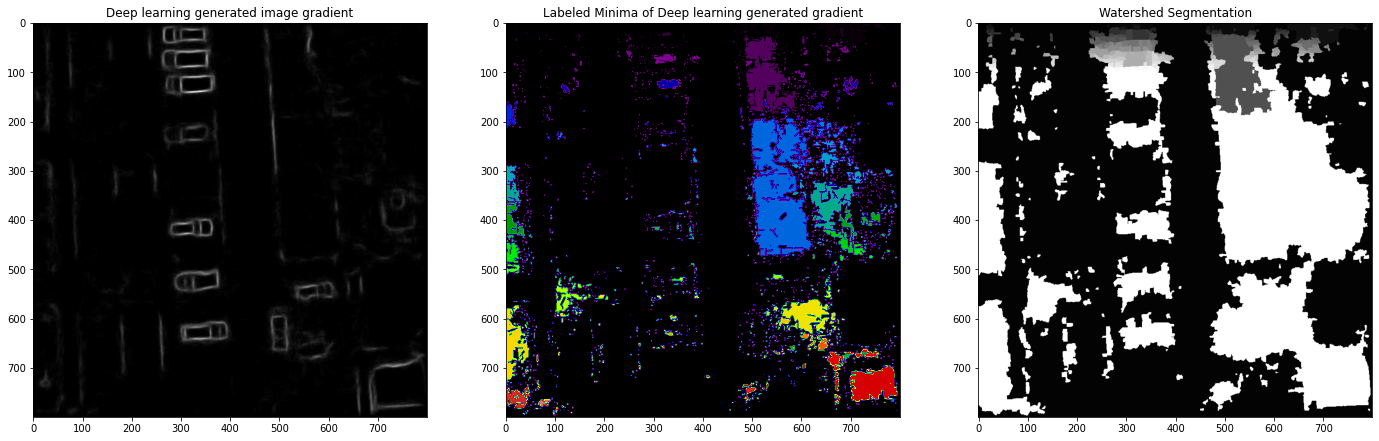

In [61]:
# Your work here
# Open and visualize the RGB image "potsdam_RGB_2.tiff" (Image source: https://www2.isprs.org/commissions/comm2/wg4/benchmark/2d-sem-label-potsdam/)
postdam_gradient = plt.imread("/content/drive/MyDrive/UBS/Computer Vision/Graph-based Processing/Lab/potsdam_RGB_2_gradient.bmp")
postdam_gradient = np.asarray(postdam_gradient)

local_minima_grad = extrema.local_minima(postdam_gradient)
labeled_minima_grad, ncomponents_grad = label(local_minima_grad[:, :, 0], structure)
watershed_new_grad = watershed(postdam_gradient, labeled_minima_grad.reshape([800, 800, 1]))

# plot the images
fig, axs = plt.subplots(1, 3, figsize = (24, 12))
axs[0].imshow(postdam_gradient, cmap=plt.cm.nipy_spectral)
axs[0].set_title("Deep learning generated image gradient")

axs[1].imshow(labeled_minima_grad, cmap=plt.cm.nipy_spectral)
axs[1].set_title("Labeled Minima of Deep learning generated gradient")

# display the watershed segments
axs[2].imshow(watershed_new_grad, cmap=plt.cm.nipy_spectral)
axs[2].set_title("Watershed Segmentation")



#### Marker-based watershed segmentation

/usr/local/lib/python3.7/dist-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Text(0.5, 1.0, 'Watershed Segmentation')

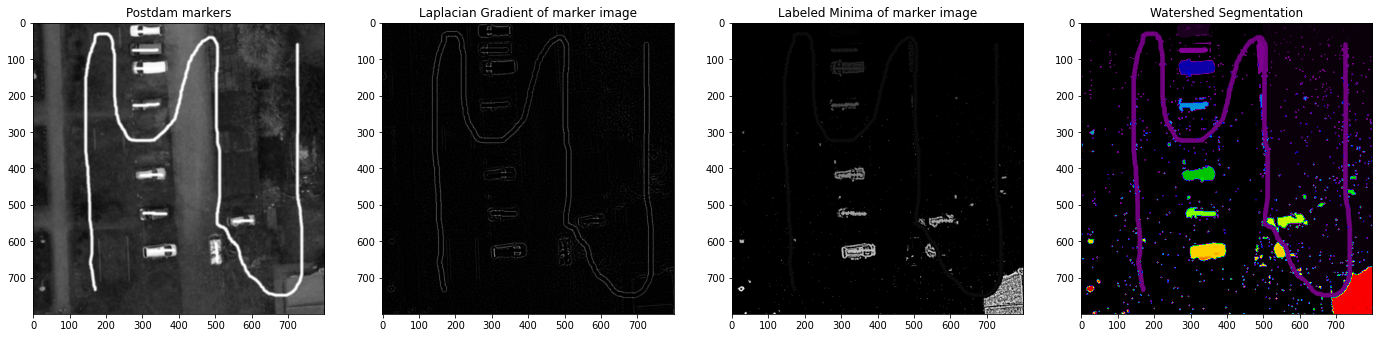

In [62]:
# marker-based watershed segmentation -- use the marker image 
postdam_markers = plt.imread("/content/drive/MyDrive/UBS/Computer Vision/Graph-based Processing/Lab/potsdam_RGB_2_markers_2.bmp")
postdam_markers = postdam_markers[:, :, 2]
postdam_markers = np.asarray(postdam_markers)

smoother = np.ones((5,5),np.float32)/25

marked_smooth_image = cv2.filter2D(np.uint8(postdam_markers),-1,smoother)

marked_laplacian_gradient = cv2.filter2D(np.uint8(marked_smooth_image),-1,kernel)

marked_local_minima = extrema.local_minima(marked_laplacian_gradient)

labeled_marked_grad= label(marked_local_minima, structure)[0]

marked_watershed = watershed(marked_laplacian_gradient, labeled_marked_grad)

# plot the images
fig, axs = plt.subplots(1, 4, figsize = (24, 12))
axs[0].imshow(marked_smooth_image, cmap='gray')
axs[0].set_title("Postdam markers")

axs[1]. imshow(marked_laplacian_gradient, cmap='gray')
axs[1].set_title("Laplacian Gradient of marker image")

axs[2].imshow(labeled_marked_grad, cmap='gray')
axs[2].set_title("Labeled Minima of marker image")

# display the watershed segments
axs[3].imshow(marked_watershed, cmap=plt.cm.nipy_spectral)
axs[3].set_title("Watershed Segmentation")

In the marker-based watershed segmentation, we see a reduction in the oversegmentation observed in the initial case of just working strictly with the watershed segmentation without the markers included in the image. 

### **Exo 4: Let's try a another advanced method**

Now, let's experiment the graph-based method from the paper *Efficient Graph-Based Image Segmentation by Felzenszwalb & Huttenlocher*, by using the function *felzenszwalb* of the skimage library:

```
felzenszwalb(img, scale=5000, sigma=0.8)
```
where:
- scale is the constant *k* parameter (larger *k* leads to larger regions in the segmentation)
- sigma is the width of the Gaussian smooting applied to the input image

Try different values of *k* and *sigma*. Apply to segment the RGB Potsdam image.

Observe and comment on your obtained results.




Text(0.5, 1.0, 'Scale: 1000, sigma: 1')

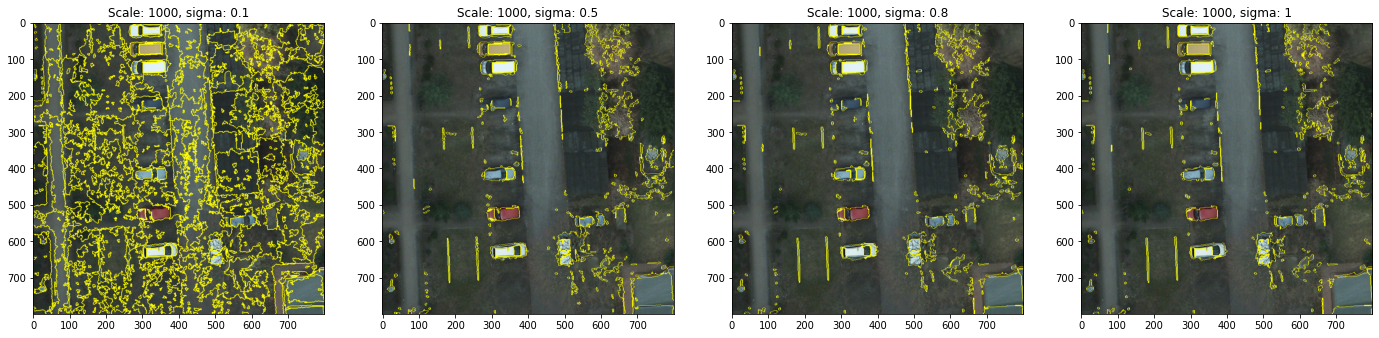

In [63]:
# your work here
f1 = felzenszwalb(potsdam_rgb, scale = 1000, sigma = 0.1)
f2 = felzenszwalb(potsdam_rgb, scale = 1000, sigma = 0.5)
f3 = felzenszwalb(potsdam_rgb, scale = 1000, sigma = 0.8)
f4 = felzenszwalb(potsdam_rgb, scale = 1000, sigma = 1)


fig, axs = plt.subplots(1, 4, figsize = (24, 12))

axs[0].imshow(mark_boundaries(potsdam_rgb, f1))
axs[0].set_title("Scale: 1000, sigma: 0.1")

axs[1].imshow(mark_boundaries(potsdam_rgb, f2))
axs[1].set_title("Scale: 1000, sigma: 0.5")

axs[2].imshow(mark_boundaries(potsdam_rgb, f3))
axs[2].set_title("Scale: 1000, sigma: 0.8")

axs[3].imshow(mark_boundaries(potsdam_rgb, f4))
axs[3].set_title("Scale: 1000, sigma: 1")

Text(0.5, 1.0, 'Scale: 3000, sigma: 0.5')

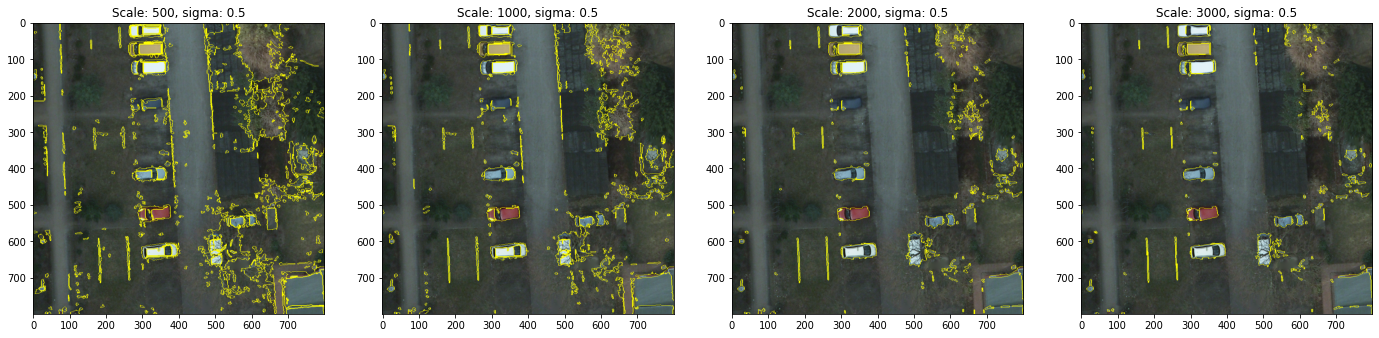

In [64]:
# your work here
f1 = felzenszwalb(potsdam_rgb, scale = 500, sigma = 0.5)
f2 = felzenszwalb(potsdam_rgb, scale = 1000, sigma = 0.5)
f3 = felzenszwalb(potsdam_rgb, scale = 2000, sigma = 0.5)
f4 = felzenszwalb(potsdam_rgb, scale = 3000, sigma = 0.5)

fig, axs = plt.subplots(1, 4, figsize = (24, 12))

axs[0].imshow(mark_boundaries(potsdam_rgb, f1))
axs[0].set_title("Scale: 500, sigma: 0.5")

axs[1].imshow(mark_boundaries(potsdam_rgb, f2))
axs[1].set_title("Scale: 1000, sigma: 0.5")

axs[2].imshow(mark_boundaries(potsdam_rgb, f3))
axs[2].set_title("Scale: 2000, sigma: 0.5")
-
axs[3].imshow(mark_boundaries(potsdam_rgb, f4))
axs[3].set_title("Scale: 3000, sigma: 0.5")

As observed above, we can see a play around with the two paramaters of the Felzenswalb algorithm -- the scale and the sigma. The scale value is used to modulates the strength of the segmentation produced. We observe that lower scale values produces coarser segments whereas larger scale values produces larger and finer segments (that is, it groups larger image objects together). The sigma values on the other hand is used to overall number of segments that can be extracted from the image. As observed above, lower sigma values extract more image segments than higher ones.